In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Finite state machine

A **finite state machine**(FSM) is a synchronous machine which holds some state.
On each **active clock edge**, the FSM produces an output, and update its next state, base on the inputs and present state.

FSM falls into 2 types:
* Moore FSM
    * output is function of present state and inputs
* Mealy FSM
    * output is function of present state only

## Structure


To implement an FSM, we can split it into 3 components.

### State memory

We store the state memory in flip-flops.
If there are $N$ states, then we require $\log_2 N$ number of flip-flops to represent the states.

### Next state logic

To compute the next state, we need some circuit which takes the inputs + the current state and produces the next state.

### Output logic

While we compute the next state, we also need another circuit which produces the current output.

This circuit will take current state (and also inputs if it is a *Mealy FSM*) and produces an output.

## State transition diagram

The **state transition diagrams** shows us all the state and transitions of an FSM.

It has the following components:
* Circles represents states
* Arcs represents transitions between states
    * Labels tells us the condition of which triggers the transition
    * Transition occurs on the active edge of the clock
* Arcs that do not originate from a circle are initial transitions into an initial state
* For each state, there can only be 1 transition possible for combination of inputs

##  Example

Suppose we are tasked to design a simple traffic controller.

The controller is on an intersection of two streets, A and B.

If light A is green, then it must stay green as long as there are cars on street A waiting.
Similarly for street B.

Once the there are no more cars waiting on that street, the light will turn yellow on the next cycle.
On the subsequent cycle, it must turn red, and the light for the other street will turn green.
Then a similar logic will apply for this other street.

### State transition diagram

In [2]:
G = nx.DiGraph()
G.add_node("S0", pos=(0, 5))
G.add_node("S1", pos=(5, 5))
G.add_node("S2", pos=(5, 0))
G.add_node("S3", pos=(0, 0))
G.add_node("OUT", pos=(-3, 5))
G.add_edge("S0", "S1")
G.add_edge("S1", "S2")
G.add_edge("S2", "S3")
G.add_edge("S3", "S0")
G.add_edge("OUT", "S0")

G.add_edge("S0", "S0")
G.add_edge("S2", "S2")

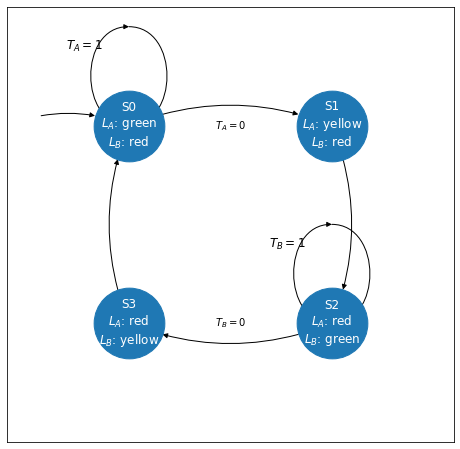

In [3]:
plt.figure(figsize=(8, 8))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=5000, nodelist=[
                       v for v in G.nodes() if v != "OUT"])
nx.draw_networkx_edges(G, pos, edgelist=[("S0", "S0")], node_size=5000)
nx.draw_networkx_edges(G, pos, connectionstyle="arc3,rad=-0.2", node_size=5000)
nx.draw_networkx_edges(G, pos, edgelist=[("S2", "S2")], node_size=5000)
nx.draw_networkx_labels(G, pos,
                        font_color="white",
                        labels={
                            "S0": "S0\n$L_A$: green\n$L_B$: red",
                            "S1": "S1\n$L_A$: yellow\n$L_B$: red",
                            "S2": "S2\n$L_A$: red\n$L_B$: green",
                            "S3": "S3\n$L_A$: red\n$L_B$: yellow",
                        })
nx.draw_networkx_edge_labels(G, pos, edge_labels={
    ("S0", "S1"): "$T_A = 0$",
    ("S2", "S3"): "$T_B = 0$",
})
nx.draw_networkx_labels(G, {v: (p[0] - 1.1, p[1] + 2) for v, p in pos.items()},
                        labels={
    "S0": "$T_A = 1$",
    "S2": "$T_B = 1$",
})
plt.xlim(-3, 8)
plt.ylim(-3, 8)
plt.show()

The above is the FSM of our traffic controller.

$L_A, L_B$ dictates the state of the traffic light for street A and B respectively.

$T_A, T_B$ is equals to 1 when there are cars (on street A and B respectively) waiting to use the intersection.

### State memory

We assign the state to bits base on the table below:

| State | $$S_1 S_0$$ |
| --- | --- |
| S0 | 00 |
| S1 | 01 |
| S2 | 10 |
| S3 | 11 |

We also need the assignment of color of the light to the bits representation:

| Output| $$L_1 L_0$$ |
| --- | --- |
| Green | 00 |
| Yellow | 01 |
| Red | 10 |

### Next state logic

Base on our FSM, we can determine the next state given the input and current state, as per the table below:

| S | $$T_A$$  | $$T_B$$ | S+ |
| --- | --- | --- | --- |
| S0 | 0 | X | S1 |
| S0 | 1 | X | S0 |
| S1 | X | X | S2 | 
| S2 | X | 0 | S3 |
| S2 | X | 1 | S2 |
| S3 | X | X | S0 |

Converting our states to their respective bit representation, to get the following table:

| $$S_1$$ | $$S_0$$ | $$T_A$$  | $$T_B$$ | $$S_1+$$ | $$S_0+$$ |
| --- | --- | --- | --- | --- | --- |
| 0 | 0 | 0 | X | 0 | 1|
| 0 | 0 | 1 | X | 0 | 0|
| 0 | 1 | X | X | 1 | 0| 
| 1 | 0 | X | 0 | 1 | 1|
| 1 | 0 | X | 1 | 1 | 0|
| 1 | 1| X | X | 0 | 0|

Then we treat $S_1+$ and $S_0+$ as functions of $S_1, S_0, T_A, T_B$, and use a [K-map](./logic_gates.ipynb#Karnaugh-Map-(K-Map)) to get the following expressions:

$$
S_1+ = \overline S_1 S_0 + S_1 \overline S_0 \\
S_0+ = \overline S_1 \overline S_0 \overline T_A + S_1 \overline S_0 \overline T_B 
$$

### Output logic

Now, we need the function which maps our current state to the output bits:

Using our state memory representation, and the known output of each state, we derive this table:

| $$S_1$$ | $$S_0$$ | $$L_A$$ | $$L_B$$ | $$L_{A1}$$  | $$L_{A0}$$ | $$L_{B1}$$ | $$L_{B0}$$ |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 0 | 0 | green | red | 0 | 0 | 1 | 0|
| 0 | 1 | yellow | red | 0 | 1 | 1 | 0|
| 1 | 0 | red | green | 1 | 0 | 0 | 0| 
| 1 | 1 | red | yellow | 1 | 0 | 0 | 1|

Another application of K-map gives us the following expressions:

$$
L_{A1} = S_1 \\
L_{A0} = \overline S_1 S_0 \\
L_{B1} = \overline S_1 \\
L_{B0} = S_1 S_0
$$

Now, we have everything we need to form our circuit.

## Modularization

Suppose that we wish for light A to stay yellow for 4 cycles instead of 1 cycle only.
Since the FSM must change state at every active edge, our FSM would look as per below, where we need 3 additional state to keep track of the counter:

In [4]:
G = nx.DiGraph()
G.add_node("S0", pos=(0, 5))
G.add_node("S1", pos=(5, 5))
G.add_node("S2", pos=(5, 0))
G.add_node("S3", pos=(0, 0))
G.add_node("OUT", pos=(-3, 5))
G.add_node("C0", pos=(5, 8))
G.add_node("C1", pos=(8, 8))
G.add_node("C2", pos=(8, 5))

G.add_edge("S0", "S1")
G.add_edge("S2", "S3")
G.add_edge("S3", "S0")
G.add_edge("OUT", "S0")

G.add_edge("S0", "S0")
G.add_edge("S2", "S2")

G.add_edge("S1", "C0")
G.add_edge("C0", "C1")
G.add_edge("C1", "C2")
G.add_edge("C2", "S2")

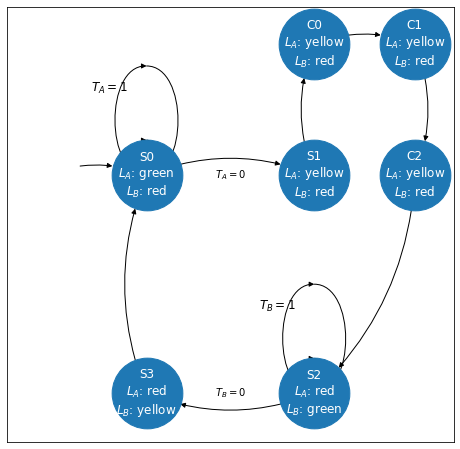

In [5]:
plt.figure(figsize=(8, 8))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=5000, nodelist=[
                       v for v in G.nodes() if v != "OUT"])
nx.draw_networkx_edges(G, pos, edgelist=[("S0", "S0")], node_size=5000)
nx.draw_networkx_edges(G, pos, connectionstyle="arc3,rad=-0.2", node_size=5000)
nx.draw_networkx_edges(G, pos, edgelist=[("S2", "S2")], node_size=5000)
nx.draw_networkx_labels(G, pos,
                        font_color="white",
                        labels={
                            "S0": "S0\n$L_A$: green\n$L_B$: red",
                            "S1": "S1\n$L_A$: yellow\n$L_B$: red",
                            "S2": "S2\n$L_A$: red\n$L_B$: green",
                            "S3": "S3\n$L_A$: red\n$L_B$: yellow",
                            "C0": "C0\n$L_A$: yellow\n$L_B$: red",
                            "C1": "C1\n$L_A$: yellow\n$L_B$: red",
                            "C2": "C2\n$L_A$: yellow\n$L_B$: red",
                        })
nx.draw_networkx_edge_labels(G, pos, edge_labels={
    ("S0", "S1"): "$T_A = 0$",
    ("S2", "S3"): "$T_B = 0$",
})
nx.draw_networkx_labels(G, {v: (p[0] - 1.1, p[1] + 2) for v, p in pos.items()},
                        labels={
    "S0": "$T_A = 1$",
    "S2": "$T_B = 1$",
})
plt.show()

This looks rather cumbersome.


Suppose we focus on the "delay FSM".
This is actually simply a mod-4 counter.

In [6]:
G = nx.DiGraph()
G.add_node("C0", pos=(0, 5))
G.add_node("C1", pos=(5, 5))
G.add_node("C2", pos=(5, 0))
G.add_node("C3", pos=(0, 0))
G.add_node("OUT", pos=(-3, 5))
G.add_edge("C0", "C1")
G.add_edge("C1", "C2")
G.add_edge("C2", "C3")
G.add_edge("C1", "C0")
G.add_edge("C2", "C0")
G.add_edge("C3", "C0")
G.add_edge("OUT", "C0")

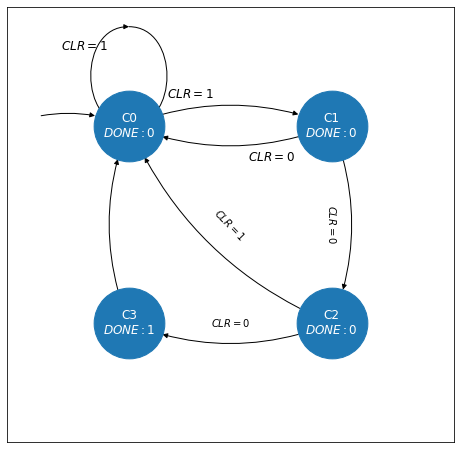

In [7]:
plt.figure(figsize=(8, 8))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=5000, nodelist=[
                       v for v in G.nodes() if v != "OUT"])
nx.draw_networkx_edges(G, pos, edgelist=[("C0", "C0")], node_size=5000)
nx.draw_networkx_edges(G, pos, connectionstyle="arc3,rad=-0.2", node_size=5000)
nx.draw_networkx_labels(G, pos,
                        font_color="white",
                        labels={
                            "C0": "C0\n$DONE: 0$",
                            "C1": "C1\n$DONE: 0$",
                            "C2": "C2\n$DONE: 0$",
                            "C3": "C3\n$DONE: 1$",
                        })

nx.draw_networkx_labels(G, {"a": (3.5, 4.2), "b": (1.5, 5.8)},
                        labels={
    "a": "$CLR = 0$",
    "b": "$CLR = 1$",
})

nx.draw_networkx_edge_labels(G, pos, edge_labels={
    ("C1", "C2"): "$CLR = 0$",
    ("C2", "C3"): "$CLR = 0$",
    ("C2", "C3"): "$CLR = 0$",
    ("C2", "C0"): "$CLR = 1$",
})
nx.draw_networkx_labels(G, {v: (p[0] - 1.1, p[1] + 2) for v, p in pos.items()},
                        labels={
    "C0": "$CLR = 1$",
})
plt.xlim(-3, 8)
plt.ylim(-3, 8)
plt.show()

Suppose we have the above FSM for a mod-4 counter with $CLR$.

We can incorporate $CLR$ into the state of our main FSM, and transit into the counter FSM when we need to perform the delay, and transit out only when $DONE = 1$.

We would obtain the FSM as per below:

In [8]:
G = nx.DiGraph()
G.add_node("S0", pos=(0, 5))
G.add_node("S1", pos=(5, 5))
G.add_node("S2", pos=(5, 0))
G.add_node("S3", pos=(0, 0))
G.add_node("OUT", pos=(-3, 5))
G.add_edge("S0", "S1")
G.add_edge("S1", "S2")
G.add_edge("S2", "S3")
G.add_edge("S3", "S0")
G.add_edge("OUT", "S0")

G.add_edge("S0", "S0")
G.add_edge("S1", "S1")
G.add_edge("S2", "S2")

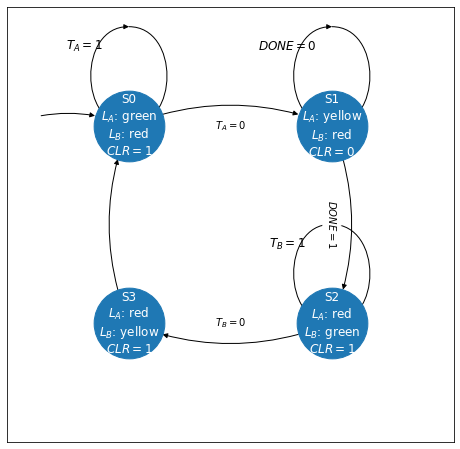

In [9]:
plt.figure(figsize=(8, 8))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=5000, nodelist=[
                       v for v in G.nodes() if v != "OUT"])
nx.draw_networkx_edges(G, pos, edgelist=[("S0", "S0")], node_size=5000)
nx.draw_networkx_edges(G, pos, edgelist=[("S1", "S1")], node_size=5000)
nx.draw_networkx_edges(G, pos, edgelist=[("S2", "S2")], node_size=5000)
nx.draw_networkx_edges(G, pos, connectionstyle="arc3,rad=-0.2", node_size=5000)
nx.draw_networkx_labels(G, pos,
                        font_color="white",
                        labels={
                            "S0": "S0\n$L_A$: green\n$L_B$: red\n$CLR = 1$",
                            "S1": "S1\n$L_A$: yellow\n$L_B$: red\n$CLR = 0$",
                            "S2": "S2\n$L_A$: red\n$L_B$: green\n$CLR = 1$",
                            "S3": "S3\n$L_A$: red\n$L_B$: yellow\n$CLR = 1$",
                        })
nx.draw_networkx_edge_labels(G, pos, edge_labels={
    ("S0", "S1"): "$T_A = 0$",
    ("S2", "S3"): "$T_B = 0$",
    ("S1", "S2"): "$DONE = 1$",
})
nx.draw_networkx_labels(G, {v: (p[0] - 1.1, p[1] + 2) for v, p in pos.items()},
                        labels={
    "S0": "$T_A = 1$",
    "S1": "$DONE = 0$",
    "S2": "$T_B = 1$",
})
plt.xlim(-3, 8)
plt.ylim(-3, 8)
plt.show()

We introduced $CLR$ into the FSM's state, and $DONE$ into the FSM's input.

Hence, as with all programming problems, we utilized another level of abstraction to simplify our FSM.